In [16]:
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

 # 1. My understanding of copy number analysis:
 1. use GATK cnv tool to call copy ratio of tumor vs a panel of normals. This reports copy ratio in .cr.seg file. the results is log2-scaled, which is log2(tumor cn/normal panel cn)
 2. GISTICS looks for copy number significantly altered regions. It is designed for SNP array copy number analysis. However it can be adapted to whole genome, exome as well. need to really keep in mind that the copy number results need to be properly standardized. it must be log2(tumour copy number) -1, which is equivalent to log2(tumor/normal copy ratio) as reported by GATK. The idea is that assuming diploid human genome, copy neutral the value is 0; negative value mean copy loss and positive means copy gain.
 
3. GATK log2 value in .cr.seg file is good for gistic. I don't have to minus 1 before input them to gisitic because the log2 copy ratio is already the value required by GISITC, which is log2(abosolute tumour copy number) -1. this is equivalent to log2(tumour copy/normal copy)
4. GISTIC markersfile is simply all the positions in the segmentation file. all the start and end positions of the segment breakpoints.
5. Andrew cherniack suggested using cr.igv.seg file. i believe this is a  mistake. By looking at the distribution of Mean_segment values, they are all positive and thus can not be the input we need for the GISTIC.

6. we also need to remove germline CNVs, TCGA manually curated a list of germline CNVs. Andrew cherniack emailed the list to me. it is saved here: /projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.

7. the seg files can be concatenated into one file and then load into igv for visualization. after selecting the region of interest, we could sort by amplification or deletion. to select region, just click the region of interest icon and then the cursor turns into a cross, click at the begin and end of the region to select. selected region will show a red horizontal bar at the cnv summary track (the top track).


# 2. references:
https://gatkforums.broadinstitute.org/gatk/discussion/11682/how-to-part-i-sensitively-detect-copy-ratio-alterations-and-allelic-segments

https://www.biostars.org/p/174382/#175590
I am currently formatting my data for use with the GISTIC 2.0.  In the documentation, it states that the Seg.CN column should be:

(log2() -1 of copy number)

 
I want to verify with someone who has used the software before that I should take the log of my copy numbers, and subtract one (1) to get this value.

Also, can anyone explain the significance of subtracting 1?
Yes, that's right. The values of this column are log2-scaled copy number relative to the normal copy number, which GISTIC assumes is 2 (diploid), so in this format the neutral regions will have a value 0.0, losses are negative numbers, and gains are positive.

Subtracting 1 after taking the log is the same as dividing by 2 before taking the log -- you're dividing the observed absolute copy number (e.g. 3) by the expected copy number (2): log2(3/2) = log2(3) - log2(2) = log2(3) - 1 = +0.58

(Why do they do this transformation? This format, SEG, was originally designed for array CGH and SNP arrays, where the measured values are log-scaled ratios like this, not absolute copy numbers.)

Try a number fairly close to zero, appropriate for the accuracy/precision of the measurement -- e.g. 0.001 in absolute scale is roughly -10 in log2 scale. GISTIC should handle these values OK.



## how to make the markersfile

https://gist.github.com/sbamin/8c2c836992552d68a17e99feddf8fac1
http://crazyhottommy.blogspot.com/2017/11/run-gistic2-with-sequenza-segmentation.html
marker file:

sed '1d' gistic2_segments.tsv | cut -f2,3 > markers.txt

sed '1d' gistic2_segments.tsv | cut -f2,4 >> markers.txt

sort the files by chromosome, take the unique ones and number the markers.

cat markers.txt | sort -V -k1,1 -k2,2nr | uniq | nl > markers_gistic.txt

rm markers.txt

# 3. constants

In [34]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/gistic/'
gatkdir = '/projects/rcorbettprj2/CNV_2016/GATK4/results/'
gisticdir = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients'
meta = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/118_patients/118_patients_bam_vcf.txt'
germline_cnvf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.sorted'


# 4. make segment file

In [31]:
%%bash -s $wkdir $gatkdir $gisticdir
# segmentationfile: segment mean = log2(CN) -1
cd $1
grep -v "@" /projects/rcorbettprj2/CNV_2016/GATK4/results/*.cr.seg|\
awk -F "/" '{print $7}'|sed 's/.cr.seg:/\t/g'|\
grep -v MEAN_LOG2_COPY_RATIO|\
grep -v "GL\|MT"|sed 's/X/23/g'|sed 's/Y/24/g' > segmentationfile.txt
# filter out germline CNVs to finish
# bedtools intersect -a -b -f 0.5 -v
# see cells at the end of this notebook


In [69]:
# figure out HIV+ and - group
df2 = pd.read_csv(meta,sep='\t', usecols=['patient', 'HIV_status', 'DNA_lib', 'status'])
df2 = df2[df2.status == 'Malignant']
df2.head(2)
df2.shape

,patient,HIV_status,DNA_lib,status
0,HTMCP-03-06-02002,Negative,A37235,Malignant
2,HTMCP-03-06-02006,Negative,A37239,Malignant


(118, 4)

,0,1,2,3,4,5
0,A37234_A37159,1,10001,4190000,2661,0.516688
1,A37234_A37159,1,4190001,4289000,94,0.481328


(170689, 6)

count    170689.000000
mean         -0.178046
std           1.634436
min         -30.045690
25%          -0.342874
50%          -0.046016
75%           0.187352
max           6.622359
Name: 5, dtype: float64

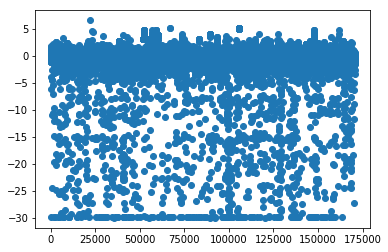

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3a4e3cd828>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3a4e3cdeb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3a4e3cd6d8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3a4e3d7588>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3a4e3d78d0>],
 'means': []}

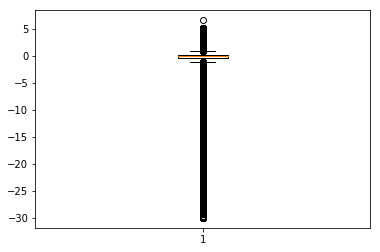

In [70]:
# look at copy ratio distribution:
df = pd.read_csv(f'{wkdir}segmentationfile.txt', sep='\t', header=None)

df.head(2)
df.shape
df[5].describe()
plt.scatter(range(0, df.shape[0]), df[5])
plt.show()
plt.boxplot(df[5])

In [71]:
df.head(2)
df['DNA_lib'] = df[0].apply(lambda x: x.split('_')[0])
df.drop(0, inplace=True, axis=1)
df.head(2)
df.shape
# df['DNA_lib'] = df[0].

,0,1,2,3,4,5
0,A37234_A37159,1,10001,4190000,2661,0.516688
1,A37234_A37159,1,4190001,4289000,94,0.481328


,1,2,3,4,5,DNA_lib
0,1,10001,4190000,2661,0.516688,A37234
1,1,4190001,4289000,94,0.481328,A37234


(170689, 6)

In [85]:
df3 = pd.merge(df, df2, left_on='DNA_lib', right_on='DNA_lib')
df3.shape

(170689, 9)

In [86]:
df3 = df3[df3.HIV_status == 'Negative']

In [87]:
df3.head(2)
df3.shape

,1,2,3,4,5,DNA_lib,patient,HIV_status,status
1147,1,10001,16901000,13226,-0.027289,A37235,HTMCP-03-06-02002,Negative,Malignant
1148,1,16901001,17205000,171,-0.103116,A37235,HTMCP-03-06-02002,Negative,Malignant


(70467, 9)

In [88]:
df3 = df3[['patient', 1,2,3,4,5]]
df3.to_csv(f'{wkdir}segmentationfile.txt', sep='\t', index=False, header=None)

# 5. make markersfile

In [89]:
%%bash -s $wkdir $gatkdir $gisticdir
cd $1
cut -f 2,3 segmentationfile.txt > start.tmp
cut -f 2,4 segmentationfile.txt > end.tmp
cat start.tmp end.tmp|sort -k1n -k2n|uniq>start_end.tmp
cat -n start_end.tmp |sed 's/ //g'|awk '{print "seg_starts_ends_"$0}'> markersfile.txt
rm *.tmp


In [14]:
# these are outdated
# %%bash -s $wkdir $gatkdir $gisticdir
# cd $1
# cut -f 2,3 segmentationfile.txt > start.tmp
# cut -f 2,4 segmentationfile.txt > end.tmp
# cat start.tmp end.tmp|sort -k1n -k2n|uniq>additional_start_end.tmp
# cut -f 2- /home/szong/bin/GISTIC_2_0_22/markersfile.txt > snp.tmp
# cat snp.tmp additional_start_end.tmp |sort -k1n -k2n|uniq>combine.tmp


# cat -n combine.tmp |sed 's/ //g'|awk '{print "SNP6_probe_"$0}'> markersfile.txt 

In [77]:
%%bash  -s $wkdir $gatkdir $gisticdir
cd $1
cp segmentationfile.txt $3
cp markersfile.txt $3

# run gistic at gistic directory: modify the run script, run locally, not working on gphosts
bash run_gistic_script_gatk_118.sh gatk_118_patients

now we could just run with csh command like this: 

csh -f run_gistic_script_tcga.sh tcga

# minus germline events based on the list Andew Cherniack sent

In [15]:
%%bash
# cd /home/szong/bin/GISTIC_2_0_22/gatk_118_patients
# cd /home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos
# cd /home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg
cd /home/szong/bin/GISTIC_2_0_22/tcga
inseg=segmentationfile.txt
# germline=/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt.sorted
# bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
# awk '{print $2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$1}' $inseg|sort -k1n -k2n -k3n > $inseg.sorted
# $bedtools intersect -a $inseg.sorted -b $germline -f 0.75 -wa -v |awk '{print $6"\t"$1"\t"$2"\t"$3"\t"$4"\t"$5}'> $inseg.sorted.no.germline
# mv $inseg.sorted.no.germline segmentationfile.txt
# rm $inseg.sorted
# # make marker file
# cut -f 2,3 $inseg.sorted.no.germline > start.tmp
# cut -f 2,4 $inseg.sorted.no.germline > end.tmp

cut -f 2,3 $inseg > start.tmp
cut -f 2,4 $inseg > end.tmp

cat start.tmp end.tmp|sort -k1n -k2n|uniq>start_end.tmp
cat -n start_end.tmp |sed 's/ //g'|awk '{print "seg_starts_ends_"$0}'> markersfile.txt
rm *.tmp
